# D214 Capstone - Disneyland Reviews Sentiment Analysis

### David Fabian
### WGU
### D214 Capstone

#### Intro: This workbook is composed of the analysis for Disneyland reviews which comes from kaggle.com. This analysis studies how accurately can neural networks can predict customer sentiment based off their park reviews (1-5).  

## Data Extraction and Data Cleaning

### Import 

In [1]:
#numpy is essential to import for dataframe manipulation
import numpy as np
#pandas in order to extract our csv file into a dataframe
import pandas as pd
#importing matplotlib for creating visuals for eda and analysis of model
import matplotlib.pyplot as plt
#import sklearn 
import sklearn

In [2]:
#incase we have annoying warnings that provide no use and make the notebook look messy
import warnings


In [3]:
#import csv file as a dataframe
reviews_file = 'DisneylandReviews.csv'
#the encoding was found from the kaggle source
disney_r_df = pd.read_csv(reviews_file, encoding="cp1252")

In [4]:
#get an idea of the data we are working with
#We can see we have a lot of data to work with and to clean
disney_r_df.head(10)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong
5,670591897,3,2019-4,Singapore,"Have been to Disney World, Disneyland Anaheim ...",Disneyland_HongKong
6,670585330,5,2019-4,India,Great place! Your day will go by and you won't...,Disneyland_HongKong
7,670574142,3,2019-3,Malaysia,Think of it as an intro to Disney magic for th...,Disneyland_HongKong
8,670571027,2,2019-4,Australia,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong
9,670570869,5,2019-3,India,I can go on talking about Disneyland. Whatever...,Disneyland_HongKong


### Check for nulls and duplicates 

In [5]:
#here we use the isnull() method and use .sum() to add up all the nulls listed
#for each column it will have the amount
print(disney_r_df.isnull().sum())

Review_ID            0
Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
Branch               0
dtype: int64


In [6]:
#find any duplicate ids and count them
#it shows we have 20
print(disney_r_df['Review_ID'].duplicated().sum())

20


In [7]:
#drop the duplicates in the review id column and keep first as in keep the first appearance
disney_r_df = disney_r_df.drop_duplicates(subset=['Review_ID'], keep='first')

In [8]:
#check to make sure they are gone
print(disney_r_df['Review_ID'].duplicated().sum())

0


In [9]:
#see if there other duplicates that exist
#drop them with the drop_duplicates method
disney_r_df = disney_r_df.drop_duplicates()

In [10]:
#ensure there are 0 duplicates
print(disney_r_df.duplicated().sum())

0


### Set to California Branch Only 

In [11]:
#here we need to specify to only include reviews for the California Branch
disney_r_df = disney_r_df[disney_r_df['Branch'] == 'Disneyland_California']

In [12]:
#check how much data we have 
disney_r_df.shape

(19400, 6)

### Find and Remove the Unique Characters to Remove To Prepare for Model 

In [13]:
#here we start by importing regular expression to clean the review column
import re

In [14]:
#make variable called reviews joined and store all 
reviews_joined = ''.join(disney_r_df['Review_Text'].astype(str))

#find the unique characters
#set will not keep duplicates only one of each
unique_characters = set(reviews_joined)
#print to see what is unique
print(unique_characters)

{'6', 'W', 'w', '7', 'A', '&', '?', ' ', '~', 'j', 'v', '4', "'", 'Y', 'm', '9', 'f', 'M', 'd', 'b', 'C', 'U', 'O', ':', '1', 'G', 'x', 'h', 'T', 'q', 'I', 'D', 'K', 'H', 'l', 'N', 'F', 'k', 'o', 'r', '^', ';', '@', 'P', 'E', 'X', 'z', 'y', '2', 'V', 'J', '8', 'S', 'n', '3', 'c', 'g', 'i', '`', '$', 'L', 'p', 'R', '*', '(', 't', 'B', ')', 's', '.', 'e', '!', '0', 'Z', 'u', '5', 'a', 'Q', '%', ','}


In [15]:
#here we need to keep only alphanumeric and we use the re.sub to specify 
disney_r_df['Review_Text'] = disney_r_df['Review_Text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]', '', str(x)))
#print the first row to show it works
print(disney_r_df['Review_Text'].iloc[0])

This place has always been and forever will be special The feeling you get entering the park seeing the characters and different attractions is just priceless This is definitely a dream trip for all ages especially young kids Spend the money and go to Disneyland you will NOT regret it


In [16]:
#lowercase all the reviews
disney_r_df['Review_Text'] = disney_r_df['Review_Text'].str.lower()
#here we can ensure it is all lowercase
print(disney_r_df['Review_Text'].iloc[0])

this place has always been and forever will be special the feeling you get entering the park seeing the characters and different attractions is just priceless this is definitely a dream trip for all ages especially young kids spend the money and go to disneyland you will not regret it


### Make a Copy For EDA 

In [17]:
#creating a separate copy to use for presentation
disney_r_df.to_csv('eda_disney.csv')

### Tokenization and Lemmatization Process 

In [18]:
#importing tensor flow 
#tensorflow is used to support the llms
import tensorflow as tf
#importing keras will give us ability to build and train models
#can use tokenizer and lemmatizer
from tensorflow import keras
#need the natural language toolkit to import the punkt and wordnet
import nltk
#tokenize to split text into sentences
from nltk.tokenize import word_tokenize
#lemmatizer will be used to make words go to the base form
#waiting turns into wait for the base form
from nltk.stem import WordNetLemmatizer
#tokenzer to we can create a tokenizer object 
from tensorflow.keras.preprocessing.text import Tokenizer
#need pad_sequences in order to make sequences the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
#spacy to load model and more methods provided by it 
import spacy


In [19]:
#download punkt for tokenizer support
#quiet true for no output
#punk is a pretrained tokenizer model that is used to split the reviews
nltk.download('punkt',quiet = True)
#download wordnet
#wordnet is a lexical database and helps with nlp tasks
nltk.download('wordnet',quiet = True)

#create the wordnet lemmatizer and name it lemm
lemm = WordNetLemmatizer()

#create a function for preprocessing reviews individually
def preprocess_review(review):
    #tokenize the reviews into tokens/words
    toks = word_tokenize(review)
    #as mentioned here the words go into base form
    toks = [lemm.lemmatize(word) for word in toks]
    #combine to single string and return
    return ' '.join(toks)

#pass into the preprocessing function 
#overwrites the original to the lemmatized version
disney_r_df['Review_Text'] = disney_r_df['Review_Text'].apply(preprocess_review)



    
#now we have the function that tokenizes the text to words and converts to base form
#followed by joining the words into a string 

### Find the Vocabulary Size

In [20]:
#create the tokenizer object called review_tokenizer
review_tokenizer = Tokenizer()
#fit onto the new version that was lemmatized
#maps each word to the unique int
#ex wait mapped to 1 and fun mapped to 0 
review_tokenizer.fit_on_texts(disney_r_df['Review_Text'])

#find the vocab size and add one for the padding and indexing
v_size = len(review_tokenizer.word_index)+1

#now we have the total size
print("Vocab Size:", v_size )

Vocab Size: 33595


### Word Embedding Length 

In [21]:
#calculate the embedding dimension using the 4th root 
embedding_dimension_length = int(np.round(v_size **0.25))
#print the 4th root
print(embedding_dimension_length)

14


### Sequence Length 

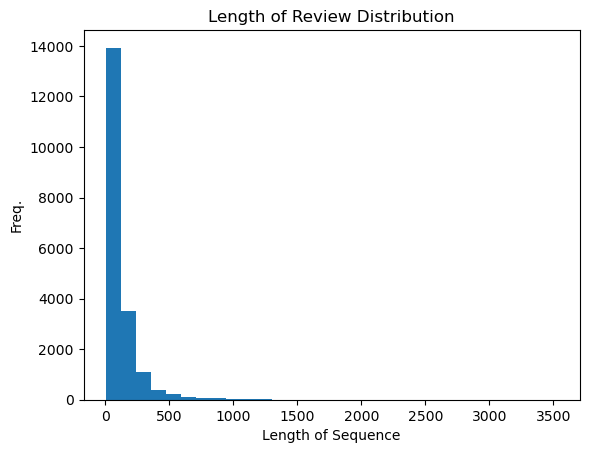

In [22]:
#sequences is set to the .text_to_sequences method
#it is a keras method from tokenizer
#converts the text into sequences of integers to represent a word
seqs = review_tokenizer.texts_to_sequences(disney_r_df['Review_Text'])

#finding length
sequence_lengths = [len(seq) for seq in seqs]

plt.hist(sequence_lengths, bins=30)
#create an x label axis label
plt.xlabel("Length of Sequence")
#create a y label axis label it is frequency
plt.ylabel("Freq.")
#title 
plt.title("Length of Review Distribution")
#display 
plt.show()

In [24]:
overall_spread = int(np.percentile(sequence_lengths, 99))

print("Overall spread of sequence length:", overall_spread)

Overall spread of sequence length: 698


### Padding 

In [25]:
#set the max sequence length for padding
max_length = 698

#pad all reviews to pre to ensure they are all same length of max length
reviews_prepadded = pad_sequences(seqs, maxlen = max_length, padding = 'pre')

#can print an example
print("Ex: ", reviews_prepadded[:1])

Ex:  [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0   

### Padded Data Exported 

In [27]:
df_padded_reviews = pd.DataFrame(reviews_prepadded)

df_padded_reviews.to_csv('padded.csv')

### Exploratory Data Analysis 

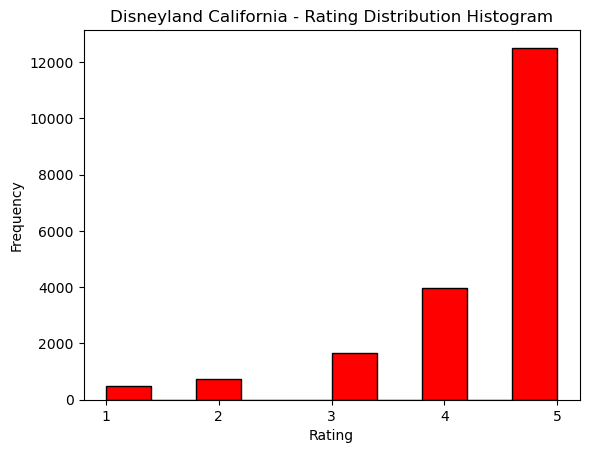

In [28]:
#use matplotlib to use the histogram function
plt.hist(disney_r_df['Rating'], edgecolor='black', color = 'red')
#set xlabel to be named Rating
plt.xlabel('Rating')
#set ylabel to be named Frequency
plt.ylabel('Frequency')
#title
plt.title('Disneyland California - Rating Distribution Histogram')
#to only show full marks and not 0.5 suffix on the xaxis
plt.xticks([1, 2, 3, 4, 5])
#show
plt.show()

In [29]:
#here we are getting the counts for each rating 1-5
#we start with one then two then so on
one_score = disney_r_df['Rating'].value_counts().get(1, 0)
two_score = disney_r_df['Rating'].value_counts().get(2, 0)
three_score = disney_r_df['Rating'].value_counts().get(3, 0)
four_score = disney_r_df['Rating'].value_counts().get(4, 0)
five_score = disney_r_df['Rating'].value_counts().get(5, 0)

print("Count of 1 ratings:", one_score)
print("Count of 2 ratings:",two_score)
print("Count of 3 ratings:", three_score)
print("Count of 4 ratings:",four_score)
print("Count of 5 ratings:", five_score )

Count of 1 ratings: 499
Count of 2 ratings: 747
Count of 3 ratings: 1660
Count of 4 ratings: 3979
Count of 5 ratings: 12515


In [30]:
#find the different locations to give business more of an idea of where people come from to
#visit the park
print(disney_r_df['Reviewer_Location'].unique())

['United States' 'Australia' 'Canada' 'Lebanon' 'New Zealand'
 'United Kingdom' 'Philippines' 'Guam' 'Bangladesh' 'Egypt' 'Sweden'
 'South Africa' 'Brazil' 'China' 'Mexico' 'Tanzania' 'Germany' 'Ecuador'
 'Portugal' 'Romania' 'Cambodia' 'Poland' 'Hungary' 'Costa Rica'
 'Singapore' 'United Arab Emirates' 'India' 'Turks and Caicos Islands'
 'Spain' 'Indonesia' 'Hong Kong' 'France' 'Japan' 'Israel' 'Macau'
 'Ireland' 'Norway' 'Italy' 'Chile' 'Malta' 'Sri Lanka' 'Puerto Rico'
 'Kuwait' 'Greece' 'Netherlands' 'Bahrain' 'Taiwan' 'Vietnam' 'Russia'
 'U.S. Virgin Islands' 'Saudi Arabia' 'Colombia' 'Switzerland' 'Slovakia'
 'Botswana' 'Iceland' 'Czechia' 'Peru' 'Malaysia' 'Qatar' 'Aruba'
 'Guatemala' 'South Korea' 'Finland' 'Cook Islands' 'Denmark' 'Austria'
 'French Polynesia' 'Thailand' 'Rwanda' 'Tunisia' 'Armenia' 'Croatia'
 'Ethiopia' 'Uruguay' 'Panama' 'Argentina' 'Vanuatu' 'Namibia' 'Belgium'
 'Pakistan' 'Cuba' 'Turkey' 'Falkland Islands (Islas Malvinas)' 'Honduras'
 'Trinidad and Tobago'

In [31]:
#going to print the top 5 using head and see the volume of each
reviewer_location_count = disney_r_df['Reviewer_Location'].value_counts().head(5)
#print top 5 and volume
print("Top 5 Countries Where Visitors Travel From")
print(reviewer_location_count)

Top 5 Countries Where Visitors Travel From
Reviewer_Location
United States     12335
Australia          2447
Canada             1842
United Kingdom     1019
New Zealand         527
Name: count, dtype: int64


### Split  70/30 training/test sets

In [32]:
from sklearn.model_selection import train_test_split
#set x to the prepadded reviews
X= reviews_prepadded
#target to the rating values 
y= disney_r_df['Rating'].values

#do a 70/30 split using train test split from sklearn
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state =12)

#print all the shapes
print("X Train/Review Shape:",X_train.shape)
print("y Train/Rating Shape",y_train.shape)
print("X Test/Review Shape:",X_test.shape)
print("y Test/Rating Shape",y_test.shape)

X Train/Review Shape: (13580, 698)
y Train/Rating Shape (13580,)
X Test/Review Shape: (5820, 698)
y Test/Rating Shape (5820,)


### Creating a Bidirectional LSTM Model 

In [33]:
#import sequential to stack layers linearly
from tensorflow.keras.models import Sequential
#Ebedding to turn integer word indices into dense vectors
#LSTM for sequence learning choice
#Dense for fully connected layer
#dropout to randomly dtop units to prevent overfitting
#globalmaxpooling1D to reduce lstm output by taking max value across time steps
#leakyrelu to allow small gradients when negative inputs occur
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,GlobalMaxPooling1D, LeakyReLU
#import adam optimizer to manually adjust from the initial
from tensorflow.keras.optimizers import Adam
#l2 to penalize large weights to combat overfitting
from tensorflow.keras.regularizers import l2
#early stopping for callback if there are no improvements during training
from tensorflow.keras.callbacks import EarlyStopping
#batch normalization to speed up the training
from tensorflow.keras.layers import BatchNormalization
#used to reduce learning rate when validation loss stops improving
from tensorflow.keras.callbacks import ReduceLROnPlateau
#calculate class weights and handle imbalanced data
from sklearn.utils.class_weight import compute_class_weight
#bidirectional was added to remember past and future.
from tensorflow.keras.layers import Bidirectional

In [34]:
#create values unique and count to see if there is a large magnitude for value count
unique, counts = np.unique(y_train, return_counts=True)
#convert to dictionary and pair each value with the volume
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{1: 355, 2: 496, 3: 1119, 4: 2842, 5: 8768}


In [35]:
#subtract for sparse categorical crossentropy
y_test= y_test-1
y_train = y_train-1

In [36]:
#confirm this is true still with counts
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0: 355, 1: 496, 2: 1119, 3: 2842, 4: 8768}


In [36]:
#create a sequential model 
model_lstm = Sequential()
#create the embedding layer. set input_dim to vocab size
#set output_dim to 200 and input_length to max length that was defined earlier
model_lstm.add(Embedding(input_dim=v_size, output_dim=200, input_length=max_length))
#Add the bidirectional lstm layer which processes sequences forward and backward
#set to 128 units in each direction. Return sequences = True to output entire sequence
#add l2 to combat overfitting and recurrent dropout to drop units in the lstms memory
model_lstm.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.002), recurrent_dropout=0.1)))
#takes the max value across each feature dimension
model_lstm.add(GlobalMaxPooling1D())
#add a dropout layer to drop 30% of input units to try to stop overfitting
model_lstm.add(Dropout(0.3))  
#batch normalization to speed up training and stabilize activations
model_lstm.add(BatchNormalization()) 
#add another dense layer with relu activation with 64 neurons
#add an l2 for overfitting issues
model_lstm.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
# add LeakyReLU to prevent dying neurons
model_lstm.add(LeakyReLU(alpha=0.1))  
#another drop out of 30% to combat overfitting of the model
model_lstm.add(Dropout(0.3))
#5 for the amount of ratings 1-5 and softmax for multiclass classification
model_lstm.add(Dense(5, activation='softmax')) 

#manually add the learning rate to a smaller one for model to learn 
optimizer = Adam(learning_rate = 0.0005)
#we add the sparse categorical crossentropy for integer labeled targets
#as said before using the accuracy metric
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#create early stopping and monitor the validation loss and patience 3
#will restore to the best epoch and stop after not improving after 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#create a lr schedule that uses the reduceLROnPlateau which dynamically changes the learning rate
#will halve it
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)


# Compute class weights to combat the class imbalance
#gives attention to the lower weighted classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Train model with class weights, early stopping, and ReduceLROnPlateau
#epochs to 15 to see results
epochs = model_lstm.fit(X_train, y_train, epochs=15, batch_size=128,
          validation_data=(X_test, y_test), class_weight=class_weight_dict,callbacks=[early_stopping,lr_schedule])




Epoch 1/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 1605s 15s/step - accuracy: 0.3094 - loss: 2.6363 - val_accuracy: 0.1739 - val_loss: 2.1066 - learning_rate: 5.0000e-04
Epoch 2/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 1554s 15s/step - accuracy: 0.4317 - loss: 1.8190 - val_accuracy: 0.5167 - val_loss: 1.7324 - learning_rate: 5.0000e-04
Epoch 3/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 1608s 15s/step - accuracy: 0.5476 - loss: 1.4925 - val_accuracy: 0.6419 - val_loss: 1.4519 - learning_rate: 5.0000e-04
Epoch 4/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 1616s 15s/step - accuracy: 0.6224 - loss: 1.2523 - val_accuracy: 0.5928 - val_loss: 1.3153 - learning_rate: 5.0000e-04
Epoch 5/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 1633s 15s/step - accuracy: 0.6763 - loss: 1.0481 - val_accuracy: 0.6125 - val_loss: 1.2174 - learning_rate: 5.0000e-04
Epoch 6/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 1673s 16s/step - accuracy: 0.7205 - loss: 0.8768 - val_accuracy: 0.5899 - val_loss: 1.1891 - learning_rate: 5.0000e-04
Epoch 7/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 1631s 

### Summary and Analysis of Results

In [39]:
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 698, 200)            │       6,719,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 698, 256)            │         336,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,220,057 (80.95 MB)

 Trainable params: 7,073,181 (26.98 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 14,146,364 (53.96 MB)

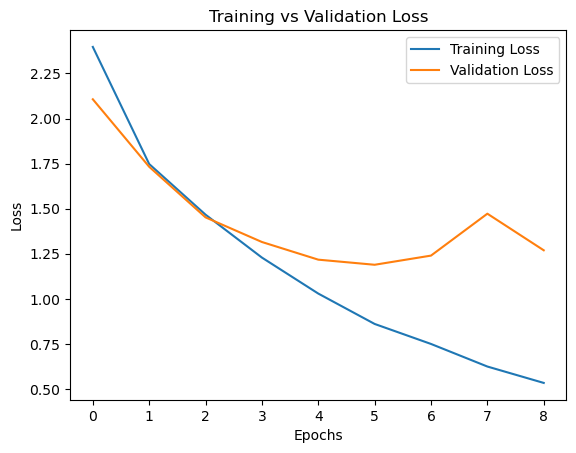

In [40]:
# Plot Loss
plt.plot(epochs.history['loss'], label='Training Loss')
plt.plot(epochs.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

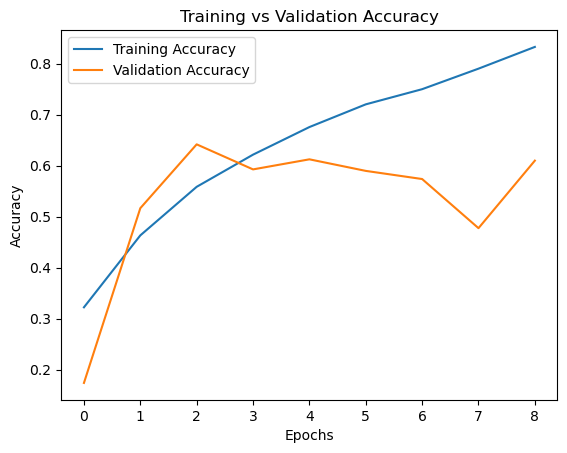

In [41]:
plt.plot(epochs.history['accuracy'], label='Training Accuracy')
plt.plot(epochs.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()

In [52]:
loss, accuracy = model_lstm.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

182/182 ━━━━━━━━━━━━━━━━━━━━ 37s 201ms/step - accuracy: 0.5934 - loss: 1.1919
Test Accuracy: 0.5899


In [38]:
from sklearn.metrics import classification_report, confusion_matrix
#here we are creating the matrix that will give the breakdown for each and all
y_pred = model_lstm.predict(X_test)
#take index of highest probability
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_labels))

182/182 ━━━━━━━━━━━━━━━━━━━━ 39s 213ms/step
              precision    recall  f1-score   support

           0       0.35      0.14      0.20       144
           1       0.28      0.27      0.27       251
           2       0.35      0.30      0.32       541
           3       0.30      0.54      0.39      1137
           4       0.86      0.69      0.76      3747

    accuracy                           0.59      5820
   macro avg       0.43      0.39      0.39      5820
weighted avg       0.66      0.59      0.61      5820



### Save Model 

In [54]:
model_lstm.save("BILSTM_model.keras")